## Overview

Plots and stats of the A Thaliana dataset, after removing outliers, before sequence clustering.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    perform_pca,
    feature_importance_plot,
)

# from subpred.eval import quick_test, models_quick_compare, full_test


## Creating the dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="keep",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose=True,
    tax_ids_filter=[3702],
    output_log="../logs/athaliana_amino_sugar_dataset.log",
    # sequence_clustering = 70
)


In [3]:
df.head()


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,2.A,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,0.0,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,0.0,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,0.0,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,2.A,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...


### Stats

Imbalanced dataset, but enough samples per class. No transporters with two known substrates.

In [4]:
df.keywords_transport.value_counts()


Sugar transport         118
Amino-acid transport     47
Name: keywords_transport, dtype: int64

In [5]:
df.keywords_location.value_counts()


Membrane;Transmembrane                                        102
Cell membrane;Membrane;Transmembrane                           51
Endoplasmic reticulum;Membrane;Transmembrane                    7
Membrane;Mitochondrion;Transmembrane                            2
Membrane;Plastid inner membrane;Transmembrane                   1
Cell membrane;Endoplasmic reticulum;Membrane;Transmembrane      1
Cell membrane;Membrane;Nucleus;Transmembrane                    1
Name: keywords_location, dtype: int64

In [6]:
df.keywords_transport_related.value_counts()


Transport             107
Symport;Transport      39
Antiport;Transport     19
Name: keywords_transport_related, dtype: int64

#### TCDB


In [7]:
df.tcdb_class.value_counts()


0.0    108
2.A     57
Name: tcdb_class, dtype: int64

## Feature generation

In [8]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)


({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f1921e5ae20>)

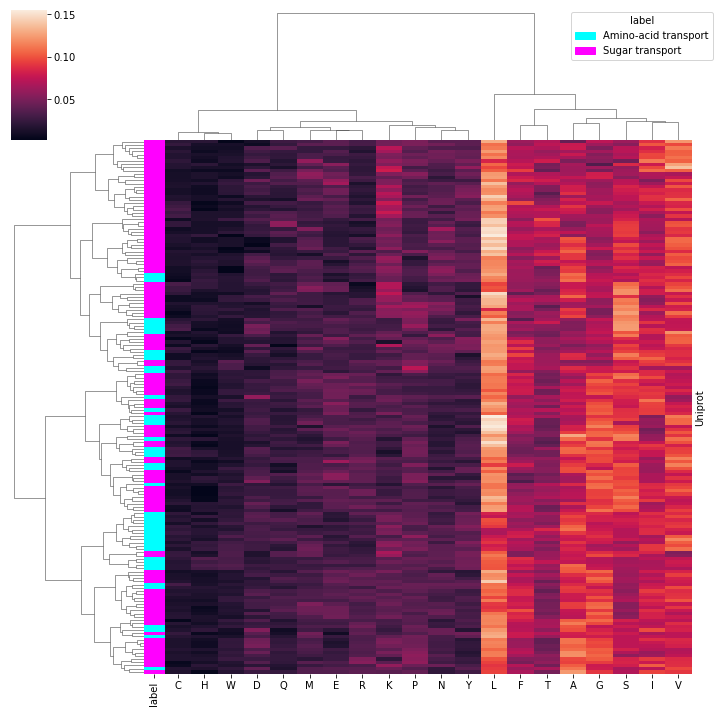

In [9]:
labeled_clustermap(df_aac, labels, xlabels="auto")


### PAAC plot

The distinction between dipeptides is much clearer after removing the outliers. The most common PAAC amino acids now correspond to the most common AAC residues.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f1919289a00>)

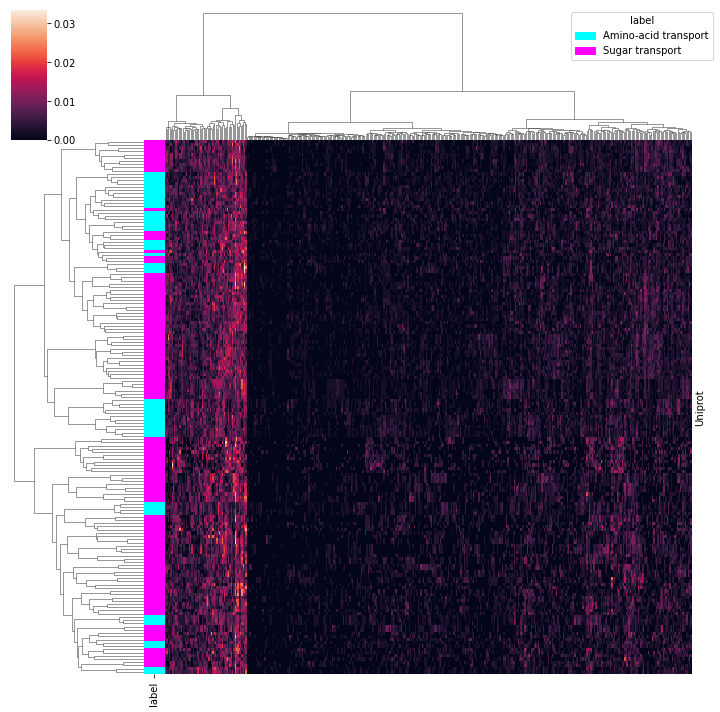

In [10]:
labeled_clustermap(df_paac, labels)


In [11]:
# cluster1 is the smaller one.
cluster0, cluster1 = get_clusters(df_paac.T, n_clusters=2)
from collections import Counter

print(len(cluster1))
counter = Counter()
for dipeptide in cluster1:
    counter[dipeptide[0]] += 1
    counter[dipeptide[1]] += 1

counter


62


Counter({'A': 16,
         'F': 15,
         'G': 15,
         'I': 16,
         'L': 17,
         'S': 16,
         'T': 12,
         'V': 16,
         'P': 1})

#### Antiport, Symport, Uniport

({'Antiport;Transport': 'cyan',
  'Symport;Transport': 'magenta',
  'Transport': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7f1916e9a730>)

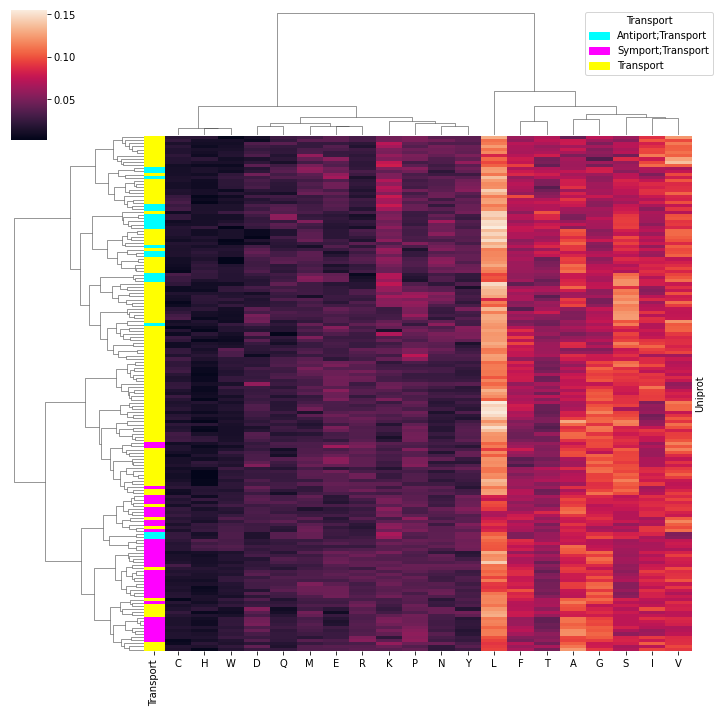

In [12]:
labeled_clustermap(
    df_aac, df.keywords_transport_related.rename("Transport"), xlabels="auto"
)



## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

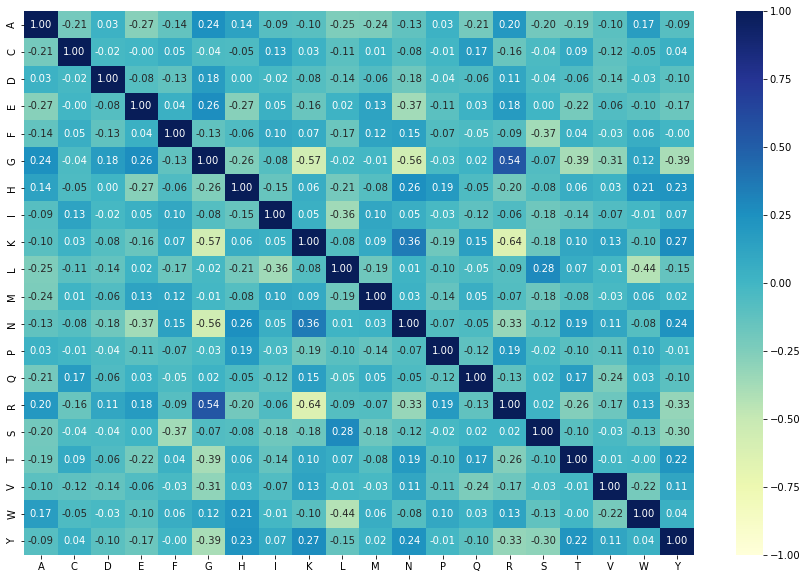

In [13]:
corr_heatmap(df_aac)


<AxesSubplot:>

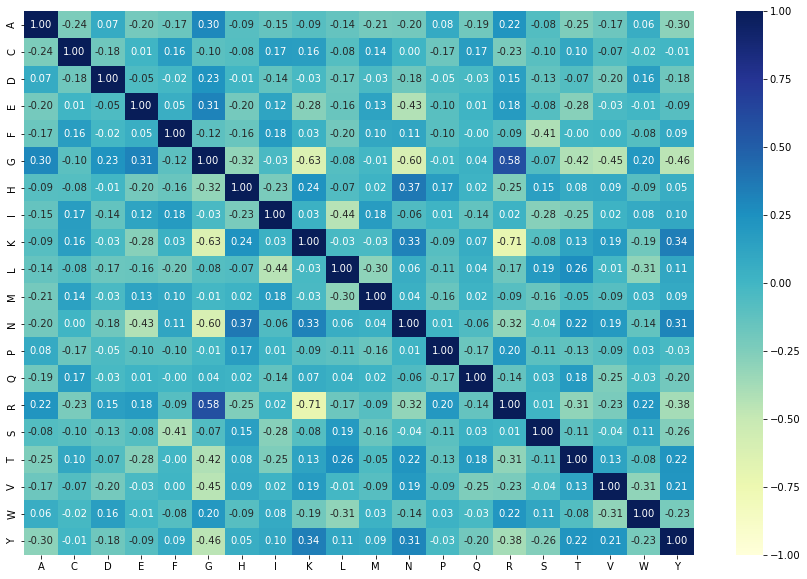

In [14]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])


<AxesSubplot:>

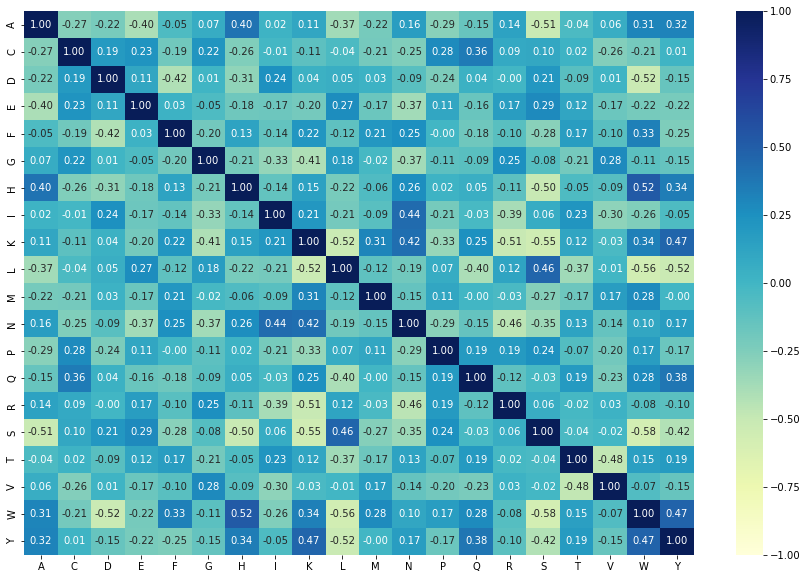

In [15]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])


#### Distribution

According to shapiro-wilk, the features now follow normal dist. Sample sizes for the dipeptides in PAAC is too low for a distribution test.

<AxesSubplot:>

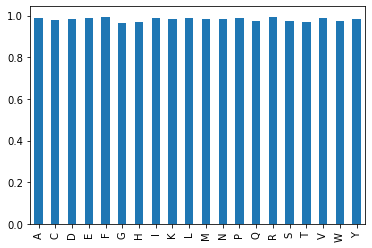

In [16]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()


## Additional plots

### TCDB class

The unclassified proteins mix well with the 2.A proteins, suggesting that they share the same sequence composition

({'0.0': 'cyan', '2.A': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f190416e8e0>)

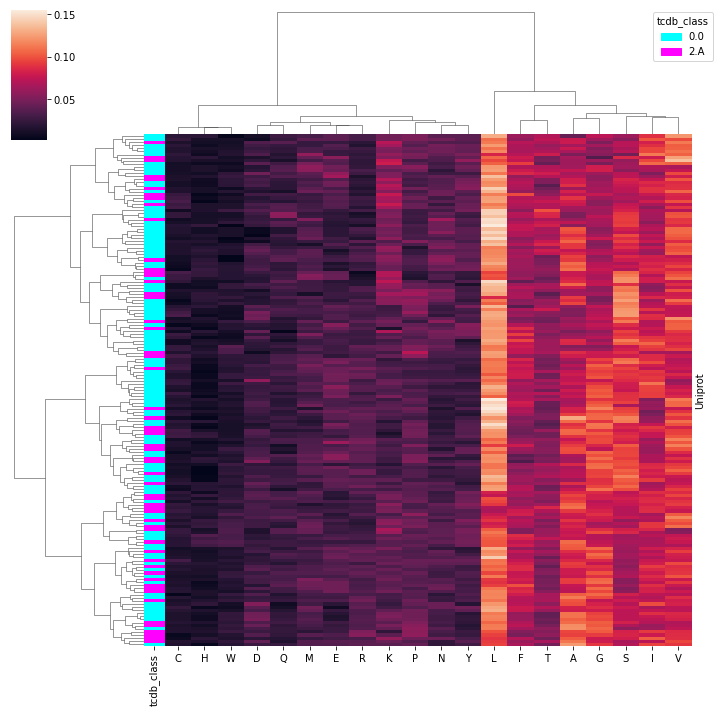

In [17]:
labeled_clustermap(df_aac, df.tcdb_class, xlabels="auto")


<AxesSubplot:>

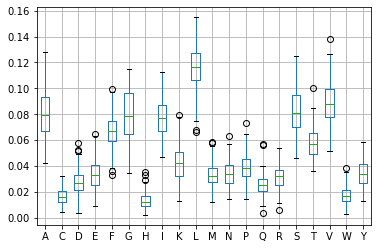

In [18]:
df_aac.boxplot()


## PCA plots

PCA plots for AAC and PAAC, the first two and three PC's.

### AAC

THe data is not that clearly separable with just the AAC and the first two or thee PCs, but a pattern emerges.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

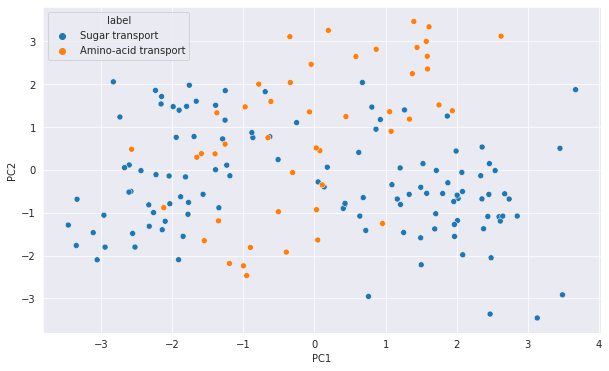

In [19]:
pca_plot_2d(df_aac, labels)


<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

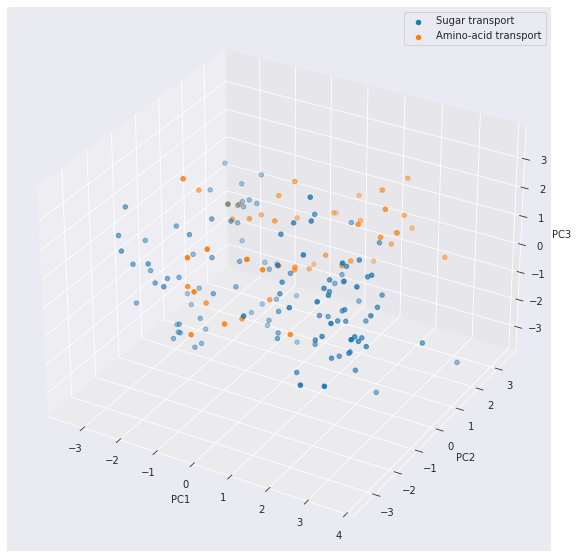

In [20]:
pca_plot_3d(df_aac, labels)


### PAAC

PAAC already works better for separating the data. The 3D plot might show the reason why SVM with RBF kernel works so well, compared to KNN and NB: There is one cluster of AA transporters in the middle, and the sugar transporters are scattered around them. A radial basis function can capture that well, especially when increasing the number of dimensions further. 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

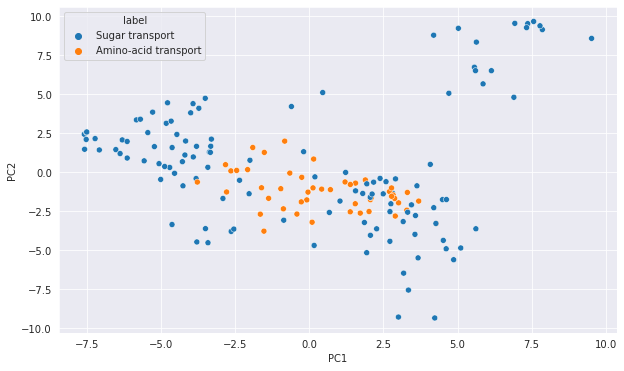

In [21]:
pca_plot_2d(df_paac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

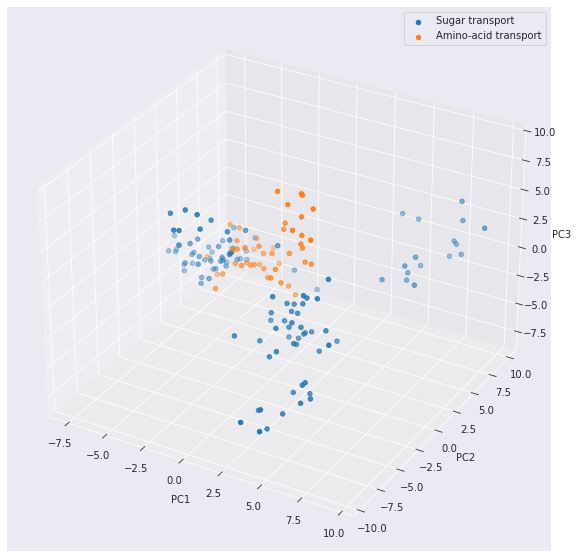

In [22]:
pca_plot_3d(df_paac, labels)


#### What are the two clusters with unusually high and low PC2? 

In [23]:
test = perform_pca(df_paac, df.keywords_transport_related, 3)
df.loc[
    test[
        (test.keywords_transport_related.str.contains("Antiport")) & (test.PC2 < -5)
    ].index
].gene_names.apply(lambda x: x.split()[0])


Uniprot
Q9SRE4    URGT1
Q9LPU2    URGT2
Q8RWW7    URGT4
Q9SZ96    URGT5
Q9FIH5    URGT3
Q9FDZ5    URGT6
Name: gene_names, dtype: object

In [24]:
df_pca3 = perform_pca(df_paac, labels, 2)

df.loc[df_pca3[(df_pca3.PC2 > 5) & (df_pca3.PC1 > 2)].index].gene_names.apply(
    lambda x: x.split()[0]
)


Uniprot
Q84WN3    SWEET17
Q8LBF7     SWEET7
Q6NQN5     SWEET3
Q9FY94    SWEET15
Q9C9M9     SWEET6
Q9LUR4    SWEET16
Q8LFH5     SWEET8
Q9SMM5    SWEET11
Q8L9J7     SWEET1
Q944M5     SWEET4
Q9ZV02     SWEET9
Q9LH79     SWEET2
Q9LUE3    SWEET10
Q9FM10     SWEET5
O82587    SWEET12
Name: gene_names, dtype: object

Answer: They are the SWEET family, and the URGT family. All of them have a normal-looking alpha-helical barrel structure, nothing out of the ordinary. 

URGT transporters carry UDB-galactose, a nucleotide sugar. They are antiporters

SWEET are normal sugar transporters that occur in many organisms.

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

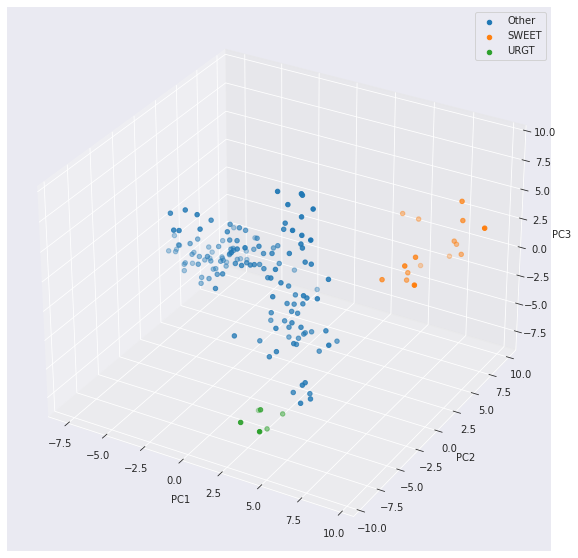

In [25]:
def map_gn(gene_names):
    first_gene = gene_names.split()[0]
    if first_gene.startswith("SWEET"):
        return "SWEET"
    elif first_gene.startswith("URGT"):
        return "URGT"
    else:
        return "Other"


pca_plot_3d(df_paac, df.gene_names.apply(map_gn))


## F score Plot

This looks different from the plot in the manuscript because we don't use clustering here yet. In the paper, we used the same dataset, but with 70% sequence clustering. 

The pattern mentioned in the manuscript, where less frequent AAs have higher importance to the classification tasks, seems to show itself more clearly after sequence clustering. (Notebook 3)  

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

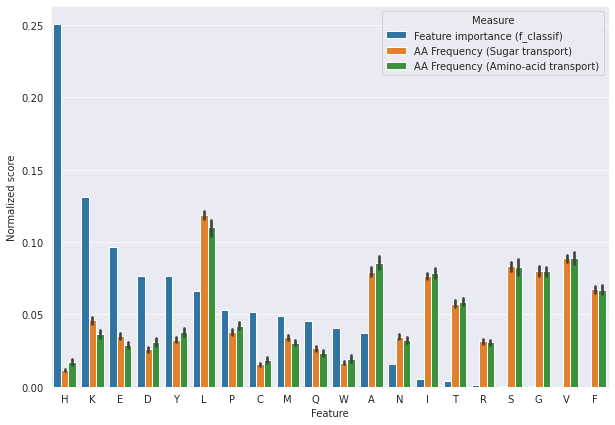

In [26]:
feature_importance_plot(df_aac, labels, method="f_classif")


<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

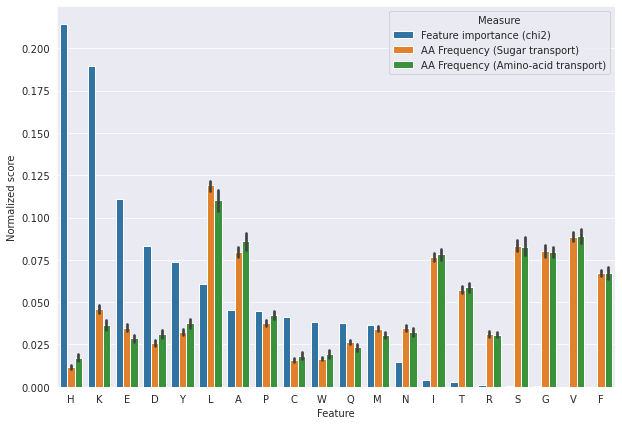

In [27]:
feature_importance_plot(df_aac, labels, method="chi2")
